In [4]:
# Import all the needed libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Import the dataset (converted from fasta to CSV format)
Seq = pd.read_csv('16s_sequences_final.csv')
Seq['Class'].unique()

array([1, 2, 3, 4, 5], dtype=int64)

In [6]:
# Import label encoder (This is for the various microorganisms)
from sklearn import preprocessing
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()
# Encode labels in column 'species'.
Seq['Class']= label_encoder.fit_transform(Seq['Class'])
Seq['Class'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [7]:
# Inspect the first five lines
Seq.head()

,ID,sequence,Class
0,FN599622.1,GAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGT...,0
1,FN599628.1,GAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGT...,0
2,FN599637.1,GAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGT...,0
3,FN599649.1,GAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAGAGCGCACGT...,0
4,FN599660.1,GAAGGGGGCTAGCGTTGTTCGGAATTACTGGGCGTAAAGCGCACGT...,0


Text(0.5, 1.0, 'Class distribution of 16s_Sequences')

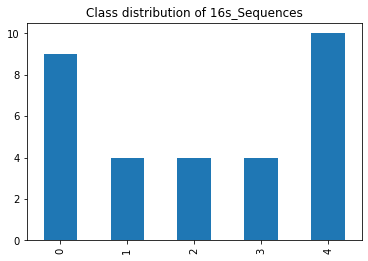

In [8]:
# Visualize the distribution of the classes
Seq['Class'].value_counts().sort_index().plot.bar()
plt.title("Class distribution of 16s_Sequences")

In [10]:
# Convert a sequence of characters into k-mer words, default size = 6 (hexamers). 
# The function Kmers_funct() will collect all possible overlapping k-mers of a 
# specified length from any sequence string

def Kmers_funct(seq, size=6):
    return [seq[x:x+size].lower() for x in range(len(seq) - size + 1)]
#convert our training data sequences into short overlapping k-mers of length 6. 
#Lets do that for each species of data we have using our Kmers_funct function.
Seq['words'] = Seq.apply(lambda x: Kmers_funct(x['sequence']), axis=1)
Seq_dna = Seq.drop('sequence', axis=1)

In [11]:
# Display the first five entries
Seq_dna.head()

,ID,Class,words
0,FN599622.1,0,"[gaaggg, aagggg, aggggg, gggggc, ggggct, gggct..."
1,FN599628.1,0,"[gaaggg, aagggg, aggggg, gggggc, ggggct, gggct..."
2,FN599637.1,0,"[gaaggg, aagggg, aggggg, gggggc, ggggct, gggct..."
3,FN599649.1,0,"[gaaggg, aagggg, aggggg, gggggc, ggggct, gggct..."
4,FN599660.1,0,"[gaaggg, aagggg, aggggg, gggggc, ggggct, gggct..."


In [12]:
# We now need to convert the lists of k-mers for each gene into string sentences of words 
# that can be used to create the Bag of Words model.

Seq_texts = list(Seq_dna['words'])
for item in range(len(Seq_texts)):
    Seq_texts[item] = ' '.join(Seq_texts[item])
#separate labels
y_Seq = Seq_dna.iloc[:, 1].values # y_Seq

In [13]:
# Display the labels
y_Seq

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64)

In [14]:
# Convert our k-mer words into uniform length numerical vectors that 
# represent counts for every k-mer in the vocabulary:

from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range=(4,4)) #The n-gram size of 4 is previously determined by testing
X = cv.fit_transform(Seq_texts)

In [15]:
# Inspect the shape of the data
print(X.shape)
# There are 31 genes converted into uniform length 
# feature vectors of 4-gram k-mer (length 6) counts.

(31, 3468)


In [16]:
# There are 31 genes converted into uniform length
# feature vectors of 4-gram k-mer (length 6) counts.

# 80% and 20% of the data was used to train and test the classifiers, respectively
# test the model.
# Next, train/test split dataset and build simple multinomial naive Bayes classifier.
# Splitting the human dataset into the training set and test set

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y_Seq, 
                                                    test_size = 0.20, 
                                                    random_state=42)

In [21]:
# Multinomial Naive Bayes Classifier

from sklearn.naive_bayes import MultinomialNB
multi_class = MultinomialNB(alpha=0.1)
multi_class.fit(X_train, y_train)

MultinomialNB(alpha=0.1)

In [22]:
# Now let’s make predictions for the Multinomial Naive Bayes Classifier
multi_pred = multi_class.predict(X_test)

In [23]:
# Performance metrics measurement: Multinomial Naive Bayes Classifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix for predictions on human test DNA sequence\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(multi_pred, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, multi_pred)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix for predictions on human test DNA sequence

Predicted  0  1  2  3  4
Actual                  
0          1  0  0  0  0
1          0  1  0  0  0
2          0  0  1  0  0
3          0  0  0  1  0
4          0  0  1  1  1
accuracy = 0.714 
precision = 0.857 
recall = 0.714 
f1 = 0.690


In [24]:
# Gaussian Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(X_train.todense(), y_train)

C:\Users\Albert Doughan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:585: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


GaussianNB()

In [25]:
# Now let’s make predictions for the Gaussian Naive Bayes Classifier
y_predGNB = GNB.predict(X_test.toarray())

In [26]:
# Performance metrics measurement: Gaussian Naive Bayes Classifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix for predictions on human test DNA sequence\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_predGNB, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_predGNB)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix for predictions on human test DNA sequence

Predicted  0  1  3  4
Actual               
0          1  0  0  0
1          0  1  0  0
2          1  0  0  0
3          0  0  1  0
4          0  0  0  3
accuracy = 0.857 
precision = 0.786 
recall = 0.857 
f1 = 0.810


C:\Users\Albert Doughan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
# Binomial Naive Bayes Classifier
from sklearn.naive_bayes import BernoulliNB
BNB = BernoulliNB()
BNB.fit(X_train, y_train)

BernoulliNB()

In [28]:
# Now let’s make predictions for the Binomial Naive Bayes Classifier
y_predBNB = GNB.predict(X_test.toarray())

In [29]:
# Performance metrics measurement: Binomial Naive Bayes Classifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix for predictions on human test DNA sequence\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(y_predBNB, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, y_predBNB)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix for predictions on human test DNA sequence

Predicted  0  1  3  4
Actual               
0          1  0  0  0
1          0  1  0  0
2          1  0  0  0
3          0  0  1  0
4          0  0  0  3
accuracy = 0.857 
precision = 0.786 
recall = 0.857 
f1 = 0.810


C:\Users\Albert Doughan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
# Logistic regression Classifier
from sklearn.linear_model import LogisticRegression
logit_class = LogisticRegression()
logit_class.fit((X_train), y_train)

LogisticRegression()

In [36]:
# Now let’s make predictions for the Logistic regression Classifier
logit_class = logit_class.predict(X_test.toarray())

In [37]:
# Performance metrics measurement: Logistic regression Classifier

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
print("Confusion matrix for predictions Logistic regression Classifier\n")
print(pd.crosstab(pd.Series(y_test, name='Actual'), pd.Series(logit_class, name='Predicted')))
def get_metrics(y_test, y_predicted):
    accuracy = accuracy_score(y_test, y_predicted)
    precision = precision_score(y_test, y_predicted, average='weighted')
    recall = recall_score(y_test, y_predicted, average='weighted')
    f1 = f1_score(y_test, y_predicted, average='weighted')
    return accuracy, precision, recall, f1
accuracy, precision, recall, f1 = get_metrics(y_test, logit_class)
print("accuracy = %.3f \nprecision = %.3f \nrecall = %.3f \nf1 = %.3f" % (accuracy, precision, recall, f1))

Confusion matrix for predictions Logistic regression Classifier

Predicted  0  1  2  3  4
Actual                  
0          1  0  0  0  0
1          0  1  0  0  0
2          0  0  1  0  0
3          0  0  0  1  0
4          0  0  0  0  3
accuracy = 1.000 
precision = 1.000 
recall = 1.000 
f1 = 1.000
